In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile, os, cv2
from tqdm.auto import tqdm
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras import layers, callbacks, utils

import imgaug as ia
from imgaug import augmenters as iaa

sns.set_style('darkgrid')

# Data Preparation

In [2]:
path_zip = '../input/denoising-dirty-documents/'
path = '/kaggle/working/'

with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
    
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [3]:
class config():
    IMG_SIZE = (420, 540)

imgs = [cv2.imread(path + 'train/' + f) for f in sorted(os.listdir(path + 'train/'))]
print('Median Dimensions:', np.median([len(img) for img in imgs]), np.median([len(img[0]) for img in imgs]))
del imgs

Median Dimensions: 420.0 540.0


In [4]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, config.IMG_SIZE[::-1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (*config.IMG_SIZE, 1))
    
    return img

In [5]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
    
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))
    
train = np.asarray(train)
train_cleaned = np.asarray(train_cleaned)
test = np.asarray(test)

In [6]:
train.shape, train_cleaned.shape, test.shape

((144, 420, 540, 1), (144, 420, 540, 1), (72, 420, 540, 1))

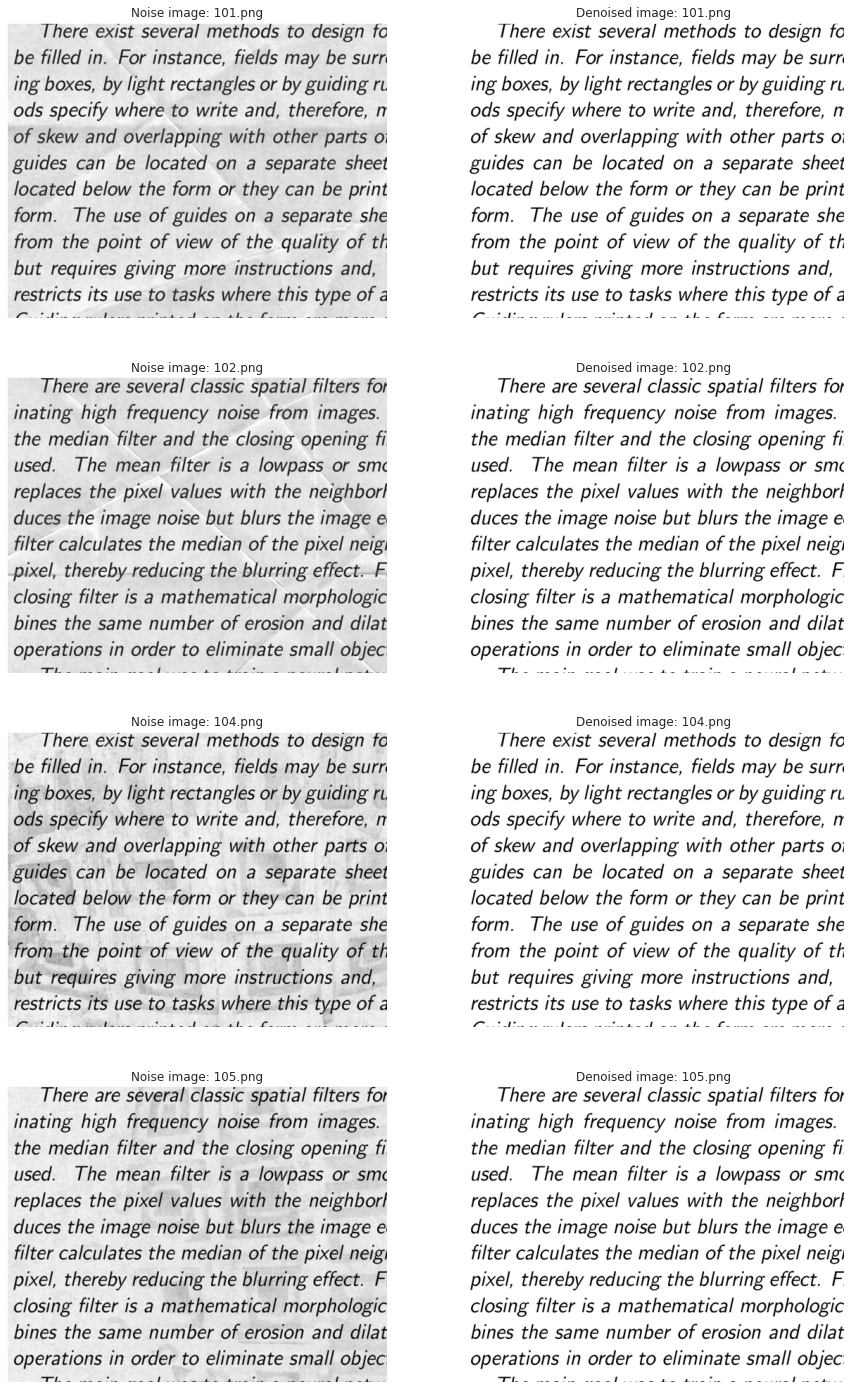

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(15,25))
for i in range(4):
    ax[i][0].imshow(tf.squeeze(train[i]), cmap='gray')
    ax[i][0].set_title('Noise image: {}'.format(train_img[i]))
    
    ax[i][1].imshow(tf.squeeze(train_cleaned[i]), cmap='gray')
    ax[i][1].set_title('Denoised image: {}'.format(train_img[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)

In [8]:
def augment_pipeline(pipeline, images, seed=19):
    ia.seed(seed)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

In [9]:
rotate90 = iaa.Rot90(1) # rotate image 90 degrees
rotate180 = iaa.Rot90(2) # rotate image 180 degrees
rotate270 = iaa.Rot90(3) # rotate image 270 degrees
random_rotate = iaa.Rot90((1,3)) # randomly rotate image from 90,180,270 degrees
perc_transform = iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
rotate10 = iaa.Affine(rotate=(10)) # rotate image 10 degrees
rotate10r = iaa.Affine(rotate=(-10)) # rotate image 30 degrees in reverse
crop = iaa.Crop(px=(5, 32)) # Crop between 5 to 32 pixels
hflip = iaa.Fliplr(1) # horizontal flips for 100% of images
vflip = iaa.Flipud(1) # vertical flips for 100% of images
gblur = iaa.GaussianBlur(sigma=(1, 1.5)) # gaussian blur images with a sigma of 1.0 to 1.5
motionblur = iaa.MotionBlur(8) # motion blur images with a kernel size 8

seq_rp = iaa.Sequential([
    iaa.Rot90((1,3)), # randomly rotate image from 90,180,270 degrees
    iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
])

seq_cfg = iaa.Sequential([
    iaa.Crop(px=(5, 32)), # crop images from each side by 5 to 32px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 1.5)) # blur images with a sigma of 0 to 1.5
])

seq_fm = iaa.Sequential([
    iaa.Flipud(1), # vertical flips all the images
    iaa.MotionBlur(k=6) # motion blur images with a kernel size 6
])

In [10]:
pipeline = [
    rotate90, rotate180, rotate270, hflip, vflip
]

In [11]:
processed_train = augment_pipeline(pipeline, train)
processed_train_cleaned = augment_pipeline(pipeline, train_cleaned)

processed_train.shape, processed_train_cleaned.shape

((864, 420, 540, 1), (864, 420, 540, 1))

In [12]:
class DenoisingAutoencoder(Model):
  def __init__(self):
    super(DenoisingAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(*config.IMG_SIZE, 1)), 
        layers.Conv2D(48, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(72, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(144, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.5),
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2D(144, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(72, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(48, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = DenoisingAutoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [13]:
es = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, restore_best_weights=True
)

# rlp = callbacks.ReduceLROnPlateau(
#     monitor='loss', factor=0.5, patience=3, min_lr=1e-6, mode='min', verbose=1
# )

history =  autoencoder.fit(
    processed_train, processed_train_cleaned, 
#     train, train_cleaned,
#     validation_split=0.1, 
    shuffle=True,
    callbacks=[es], epochs=500, batch_size=12
)

Epoch 1/500
72/72 [==============================] - 45s 621ms/step - loss: 0.0471 - mean_absolute_error: 0.1500
Epoch 2/500
72/72 [==============================] - 45s 622ms/step - loss: 0.0118 - mean_absolute_error: 0.0733
Epoch 3/500
72/72 [==============================] - 45s 622ms/step - loss: 0.0055 - mean_absolute_error: 0.0480
Epoch 4/500
72/72 [==============================] - 45s 621ms/step - loss: 0.0037 - mean_absolute_error: 0.0371
Epoch 5/500
72/72 [==============================] - 45s 621ms/step - loss: 0.0029 - mean_absolute_error: 0.0310
Epoch 6/500
72/72 [==============================] - 45s 621ms/step - loss: 0.0026 - mean_absolute_error: 0.0281
Epoch 7/500
72/72 [==============================] - 45s 624ms/step - loss: 0.0025 - mean_absolute_error: 0.0264
Epoch 8/500
72/72 [==============================] - 45s 622ms/step - loss: 0.0022 - mean_absolute_error: 0.0247
Epoch 9/500
72/72 [==============================] - 45s 621ms/step - loss: 0.0020 - mean_absolu

72/72 [==============================] - 45s 621ms/step - loss: 8.2591e-04 - mean_absolute_error: 0.0136
Epoch 73/500
72/72 [==============================] - 45s 622ms/step - loss: 8.0522e-04 - mean_absolute_error: 0.0135
Epoch 74/500
72/72 [==============================] - 45s 620ms/step - loss: 7.9983e-04 - mean_absolute_error: 0.0135
Epoch 75/500
72/72 [==============================] - 45s 621ms/step - loss: 8.1293e-04 - mean_absolute_error: 0.0136
Epoch 76/500
72/72 [==============================] - 45s 622ms/step - loss: 8.2346e-04 - mean_absolute_error: 0.0136
Epoch 77/500
72/72 [==============================] - 45s 621ms/step - loss: 7.6544e-04 - mean_absolute_error: 0.0132
Epoch 78/500
72/72 [==============================] - 45s 621ms/step - loss: 7.5620e-04 - mean_absolute_error: 0.0131
Epoch 79/500
72/72 [==============================] - 45s 621ms/step - loss: 7.5624e-04 - mean_absolute_error: 0.0131
Epoch 80/500
72/72 [==============================] - 45s 623ms/step 

Epoch 210/500
72/72 [==============================] - 45s 622ms/step - loss: 5.4240e-04 - mean_absolute_error: 0.0110
Epoch 211/500
72/72 [==============================] - 45s 621ms/step - loss: 5.1898e-04 - mean_absolute_error: 0.0108
Epoch 212/500
72/72 [==============================] - 45s 621ms/step - loss: 5.3481e-04 - mean_absolute_error: 0.0109
Epoch 213/500
72/72 [==============================] - 45s 621ms/step - loss: 5.9482e-04 - mean_absolute_error: 0.0114
Epoch 214/500
72/72 [==============================] - 45s 620ms/step - loss: 5.4409e-04 - mean_absolute_error: 0.0111
Epoch 215/500
72/72 [==============================] - 45s 621ms/step - loss: 5.3946e-04 - mean_absolute_error: 0.0111
Epoch 216/500
72/72 [==============================] - 45s 622ms/step - loss: 5.7161e-04 - mean_absolute_error: 0.0114
Epoch 217/500
72/72 [==============================] - 45s 621ms/step - loss: 5.7124e-04 - mean_absolute_error: 0.0114
Epoch 218/500
72/72 [===========================

Epoch 347/500
72/72 [==============================] - 45s 622ms/step - loss: 4.7850e-04 - mean_absolute_error: 0.0102
Epoch 348/500
72/72 [==============================] - 45s 622ms/step - loss: 4.5889e-04 - mean_absolute_error: 0.0100
Epoch 349/500
72/72 [==============================] - 45s 620ms/step - loss: 4.6324e-04 - mean_absolute_error: 0.0101
Epoch 350/500
72/72 [==============================] - 45s 621ms/step - loss: 4.5400e-04 - mean_absolute_error: 0.0100
Epoch 351/500
72/72 [==============================] - 45s 621ms/step - loss: 4.5513e-04 - mean_absolute_error: 0.0100
Epoch 352/500
72/72 [==============================] - 45s 621ms/step - loss: 4.7017e-04 - mean_absolute_error: 0.0101
Epoch 353/500
72/72 [==============================] - 45s 621ms/step - loss: 4.7883e-04 - mean_absolute_error: 0.0102
Epoch 354/500
72/72 [==============================] - 45s 622ms/step - loss: 4.6111e-04 - mean_absolute_error: 0.0100
Epoch 355/500
72/72 [===========================

Epoch 484/500
72/72 [==============================] - 45s 621ms/step - loss: 4.2393e-04 - mean_absolute_error: 0.0095
Epoch 485/500
72/72 [==============================] - 45s 621ms/step - loss: 4.1996e-04 - mean_absolute_error: 0.0095
Epoch 486/500
72/72 [==============================] - 45s 621ms/step - loss: 4.2364e-04 - mean_absolute_error: 0.0095
Epoch 487/500
72/72 [==============================] - 45s 621ms/step - loss: 4.2913e-04 - mean_absolute_error: 0.0096
Epoch 488/500
72/72 [==============================] - 45s 621ms/step - loss: 4.2059e-04 - mean_absolute_error: 0.0095
Epoch 489/500
72/72 [==============================] - 45s 621ms/step - loss: 4.1423e-04 - mean_absolute_error: 0.0094
Epoch 490/500
72/72 [==============================] - 45s 622ms/step - loss: 4.2721e-04 - mean_absolute_error: 0.0096
Epoch 491/500
72/72 [==============================] - 45s 621ms/step - loss: 4.2183e-04 - mean_absolute_error: 0.0095
Epoch 492/500
72/72 [===========================

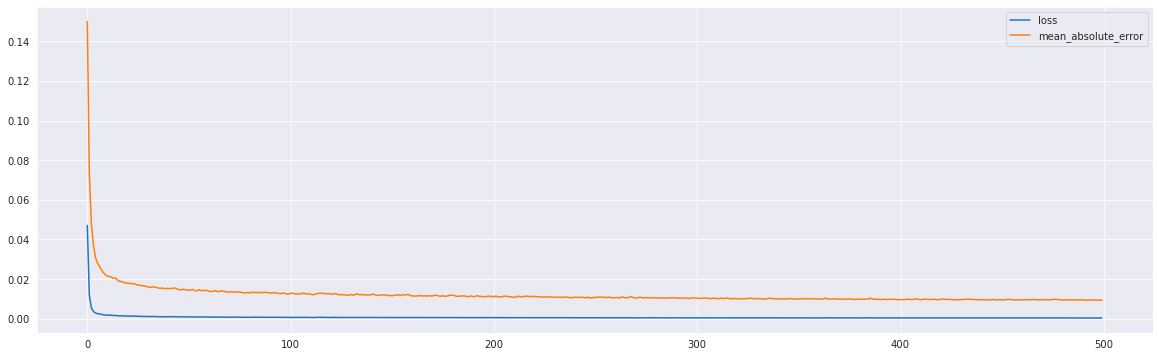

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).plot(ax=ax)
del history

In [15]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 420, 540, 48)      480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 420, 540, 72)      31176     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 420, 540, 144)     93456     
_________________________________________________________________
batch_normalization (BatchNo (None, 420, 540, 144)     576       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 270, 144)     0         
_________________________________________________________________
dropout (Dropout)            (None, 210, 270, 144)     0         
Total params: 125,688
Trainable params: 125,400
Non-trainable params: 288
________________________________________________

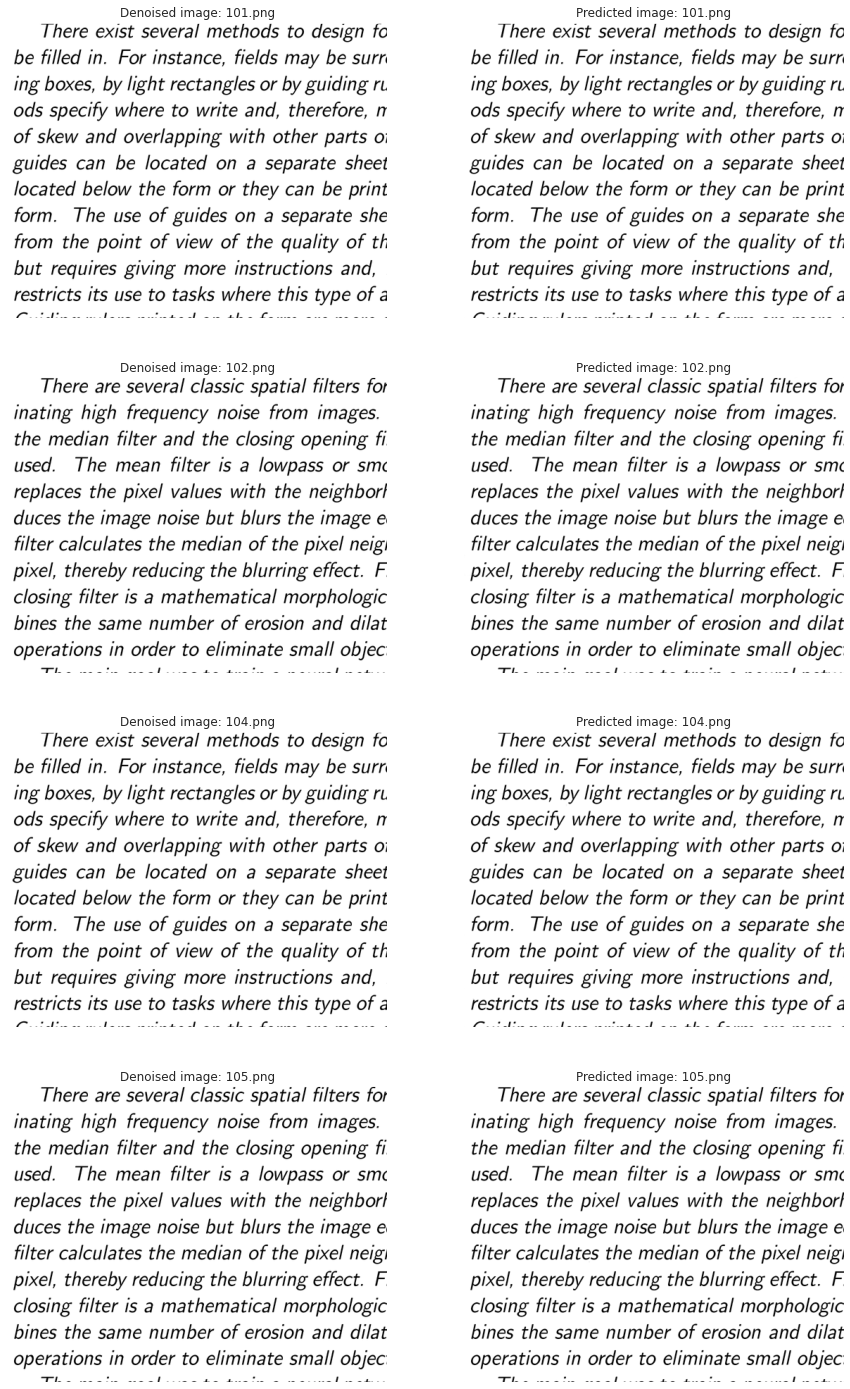

In [16]:
decoded_imgs = autoencoder(train[:4]).numpy()
    
fig, ax = plt.subplots(4, 2, figsize=(15,25))
for i in range(4):
    ax[i][0].imshow(tf.squeeze(train_cleaned[i]), cmap='gray')
    ax[i][0].set_title('Denoised image: {}'.format(train_img[i]))
    
    ax[i][1].imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
    ax[i][1].set_title('Predicted image: {}'.format(train_img[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)    

del decoded_imgs    

In [17]:
ids = []
vals = []
for i, f in tqdm(enumerate(test_img)):
    file = path + 'test/' + f
    imgid = int(f[:-4])
    img = cv2.imread(file, 0)
    img_shape = img.shape
    decoded_img = np.squeeze(autoencoder.decoder(autoencoder.encoder(test[i:i+1]).numpy()).numpy())
    preds_reshaped = cv2.resize(decoded_img, (img_shape[1], img_shape[0]))

    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

print('Length of IDs: {}'.format(len(ids)))            
pd.DataFrame({'id': ids, 'value': vals}).to_csv('submission.csv',index=False)
print('Results saved to submission.csv!')



Length of IDs: 14230080
Results saved to submission.csv!
